In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os
import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU

from sklearn.model_selection import train_test_split

from nvtabular.utils import download_file

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

In [4]:
download_file(
    "http://files.grouplens.org/datasets/movielens/ml-25m.zip",
    os.path.join(INPUT_DATA_DIR, "ml-25m.zip"),
    redownload=False
)

unzipping files: 100%|██████████| 8/8 [00:04<00:00,  1.76files/s]


In [5]:
movies = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m/movies.csv"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies["genres"] = movies["genres"].str.split("|")
movies = movies.drop("title", axis=1)
movies.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [7]:
movies.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))

In [8]:
tags = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m/tags.csv"))

In [9]:
tags = tags.drop("userId", axis=1)
tags = tags.drop("timestamp", axis=1)
tags = tags.groupby("movieId").agg({"tag": ["unique", "nunique"]})
tags.columns = tags.columns.map('s_'.join)
tags.reset_index(inplace=True)
tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [10]:
tags.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))

## Splitting into train and validation dataset

In [11]:
# TODO: Change this to a temporal split

In [12]:
ratings = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [13]:
ratings = ratings.drop("timestamp", axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [14]:
train.to_parquet(os.path.join(INPUT_DATA_DIR, "train.parquet"))
valid.to_parquet(os.path.join(INPUT_DATA_DIR, "valid.parquet"))

In [15]:
train.head()

,userId,movieId,rating
19120594,124027,56587,4.0
15253127,98809,2641,2.5
12584278,81377,122886,4.5
18034326,116853,78499,4.5
18073299,117118,1302,2.5


## Getting Started

In [16]:
# External dependencies
import os
import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
import shutil
import numpy as np

import nvtabular as nvt

from os import path

In [17]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

In [18]:
movie_genres = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))
movie_genres.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [19]:
movie_tags = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))
movie_tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [20]:
movie_tags.columns

Index(['movieId', 'tags_unique', 'tags_nunique'], dtype='object')

In [21]:
# TODO: Try applying Categorify to the tags_unique column

In [35]:
tags_ds = nvt.Dataset(movie_tags)

In [36]:
CATEGORICAL_COLUMNS = ["tags_unique", "movieId"]
CONTINUOUS_COLUMNS = ["tags_nunique"]
LABEL_COLUMNS = []

In [37]:
joined = CATEGORICAL_COLUMNS >> nvt.ops.JoinExternal(movie_genres, on=["movieId"])

In [38]:
cat_features = joined >> nvt.ops.Categorify()

In [39]:
cont_features = nvt.ColumnGroup(CONTINUOUS_COLUMNS)

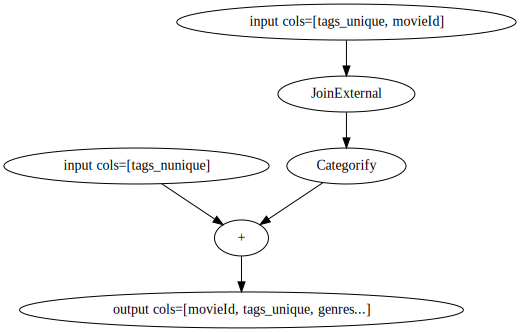

In [40]:
output = cat_features + cont_features
(output).graph

In [41]:
workflow = nvt.Workflow(output)

In [42]:
%%time
workflow.fit(tags_ds)

CPU times: user 271 ms, sys: 52.6 ms, total: 324 ms
Wall time: 327 ms


In [80]:
%time
movie_features = workflow.transform(tags_ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [81]:
ddf = movie_features.to_ddf()

In [82]:
ddf.head()

,movieId,tags_unique,genres,tags_nunique
0,1,"[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ...","[3, 4, 5, 6, 10]",126
1,2,"[1206, 4448, 5069, 5213, 7883, 8912, 9116, 925...","[3, 5, 10]",44
2,3,"[2196, 4356, 4448, 6484, 11460, 12274, 17647, ...","[6, 16]",23
3,4,"[4448, 31525, 34749, 34981, 39134, 48169, 6086...","[6, 9, 16]",8
4,5,"[4448, 5693, 6977, 8912, 23756, 25354, 28604, ...",[6],20


In [83]:
ddf.loc[45250].compute()

,movieId,tags_unique,genres,tags_nunique
45250,45251,"[19842, 32417, 40138, 43410, 47668, 58904, 595...",[1],9


In [87]:
train_ratings = movie_features.to_ddf().merge(train, on="movieId")

In [88]:
train_ratings.head()

,movieId,tags_unique,genres,tags_nunique,userId,rating
0,33499,"[28450, 30363, 32142, 60478]",[9],4,93,3.5
1,33669,[72236],"[9, 18]",1,93,5.0
2,43930,"[48205, 53440, 67112]",[8],3,93,3.5
3,44022,"[5604, 6464, 25735, 25864, 29593, 30253, 31336...","[6, 9, 20]",25,93,4.0
4,45186,[46781],[1],1,38,2.5


In [ ]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [ ]:
train_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "train.parquet")], part_size="100MB")
valid_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "valid.parquet")], part_size="100MB")

In [ ]:
%%time

workflow.fit(train_dataset)

In [ ]:
# Make sure we have a clean output path
if path.exists(os.path.join(INPUT_DATA_DIR, "train")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "train"))
if path.exists(os.path.join(INPUT_DATA_DIR, "valid")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "valid"))

In [ ]:
%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=["userId", "movieId"],
    labels=["rating"],
    dtypes=dict_dtypes,
)

In [ ]:
%time
workflow.transform(valid_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "valid"),
    shuffle=False,
    cats=["userId", "movieId"],
    labels=["rating"],
    dtypes=dict_dtypes,
)

In [ ]:
workflow.save(os.path.join(INPUT_DATA_DIR, "workflow"))

In [ ]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "valid", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

In [ ]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()